In [1]:
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

# Load four letter words 

In [2]:
# Kucera & Francis Word Pool downloaded from http://memory.psych.upenn.edu/files/wordpools/kfpool.txt
kf_corpus = pd.read_csv('kfpool.txt', header=None, sep=' ', names=['word', 'frequency'])

kf_corpus

,word,frequency
0,a,23248
1,a-coming,2
2,a-crowing,1
3,a-drinking,1
4,a-gracious,1
...,...,...
46367,zur,2
46368,zurcher,2
46369,zurich,2
46370,zwei,1


Let's see how many four letter words there are in the corpus.

In [3]:
(kf_corpus.word.str.len() == 4).sum()

2347

That is more than 1179 words reported in McClelland & Rumelhart, 1981. Probably they filtered by frequency.

In [4]:
for i in range(7):
    word_count = len(kf_corpus[(kf_corpus.word.str.len() == 4) & (kf_corpus.frequency > i)])
    print(f'There are {word_count} four letter words with frequency larger than {i}')

There are 2347 four letter words with frequency larger than 0
There are 1721 four letter words with frequency larger than 1
There are 1444 four letter words with frequency larger than 2
There are 1294 four letter words with frequency larger than 3
There are 1188 four letter words with frequency larger than 4
There are 1092 four letter words with frequency larger than 5
There are 1029 four letter words with frequency larger than 6


Frequency threshold of 4 yields the number closest to 1179.

In [5]:
four_letter_words = kf_corpus[(kf_corpus.word.str.len() == 4) & (kf_corpus.frequency > 4)]
len(four_letter_words)

1188

# Encode letters as feature bundles 

In the original model, the input letters came from a simplified font in which each letter is composed of a number of simplified line strokes (*features*) as in the following image:

![Font from Rumelhar & Siple, 1974](rumelhart-siple-font.jpg)

Here are all the features numbered from 0 to 13:

![Numbered line features](line_features.png)

A list of letters specifying which features it is composed of.

In [6]:
feature_numbers = {
    'A': [0, 1, 2, 3, 4, 6, 8],
    'B': [2, 3, 4, 5, 7, 8, 9],
    'C': [0, 1, 2, 5],
    'D': [2, 3, 4, 5, 7, 9],
    'E': [0, 1, 2, 5, 6],
    'F': [0, 1, 2, 6],
    'G': [0, 1, 2, 4, 5, 8],
    'H': [0, 1, 3, 4, 6, 8],
    'I': [2, 5, 7, 9],
    'J': [0, 3, 4, 5],
    'K': [0, 1, 6, 11, 12],
    'L': [0, 1, 5],
    'M': [0, 1, 3, 4, 10, 11],
    'N': [0, 1, 3, 4, 10, 12],
    'O': [0, 1, 2, 3, 4, 5],
    'P': [0, 1, 2, 3, 6, 8],
    'Q': [0, 1, 2, 3, 4, 5, 12],
    'R': [0, 1, 2, 3, 6, 8, 12],
    'S': [1, 2, 4, 5, 6, 8],
    'T': [2, 7, 9],
    'U': [0, 1, 3, 4, 5],
    'V': [0, 1, 11, 13],
    'W': [0, 1, 3, 4, 12, 13],
    'X': [10, 11, 12, 13],
    'Y': [9, 10, 11],
    'Z': [2, 5, 11, 13]
}

Let's draw all the letter to check that we got everything right. First, we need the coordinates of all features.

In [7]:
feature_coordinates = {
    0: [(-1, -1), (-1, 0)],
    1: [(-1, 0), (-1, 1)],
    2: [(-1, 1), (1, 1)],
    3: [(1, 1), (1, 0)],
    4: [(1, 0), (1, -1)],
    5: [(1, -1), (-1, -1)],
    6: [(0, 0), (-1, 0)],
    7  : [(0, 0), (0, 1)],
    8 : [(0, 0), (1, 0)],
    9 : [(0, 0), (0, -1)],
    10 : [(0, 0), (-1, 1)],
    11 : [(0, 0), (1, 1)],
    12 : [(0 ,0), (1, -1)],
    13 : [(0, 0), (-1, -1)]
}

Function that draws one letter:

In [8]:
def draw_letter(feature_list, feature_coordinates, axes, color='k'):
    axes.grid()
    axes.set(xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))
    
    # Remove ticks and labels from the axes
    axes.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
   
    for line_nmbr in feature_list:
        line_coords = feature_coordinates[line_nmbr]
        x_values = [line_coords[0][0], line_coords[1][0]]
        y_values = [line_coords[0][1], line_coords[1][1]]
        axes.plot(x_values, y_values, color = color, linewidth = 4)

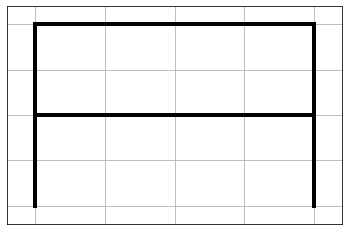

In [9]:
plt.plot()
axes=plt.gca()
draw_letter(feature_list=feature_numbers['A'], 
            feature_coordinates=feature_coordinates, 
            axes=axes)


Now, let's draw all of them.

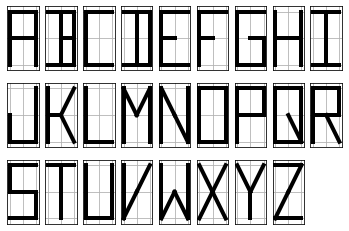

In [10]:
def draw_letter_list(letter_list, feature_numbers, feature_coordinates):
    N_letters = len(letter_list)
    fig, axs = plt.subplots(3, 9)
    for axes, lttr in zip(axs.flatten()[:N_letters], letter_list):
        plt.sca(axes)
        draw_letter(feature_numbers[lttr], feature_coordinates, axes)
    
    # Clear the last empty axes
    axs.flatten()[-1].axis('off');
    
draw_letter_list(sorted(feature_numbers.keys())[:26], feature_numbers, feature_coordinates)

![Font from Rumelhar & Siple, 1974](rumelhart-siple-font.jpg)

Looks correct.

# Feature perception

In [11]:
M = 1.0  # max activation
m = -0.2  # min activation
theta = 0.07  # decay rate
r_feature = 0  # resting state activation

In [12]:
feature_count = len(list(feature_coordinates.keys()))
position_count = 4
feature_nodes = np.zeros((position_count, feature_count))

We'll have to represent the letters as a list of binary feature flags.

In [13]:
features_binary = {
    letter: [1 if i in feature_list else 0 for i in range(feature_count)]
    for letter, feature_list in feature_numbers.items()}

features_binary

{'A': [1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0],
 'B': [0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0],
 'C': [1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 'D': [0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0],
 'E': [1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 'F': [1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 'G': [1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0],
 'H': [1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0],
 'I': [0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
 'J': [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 'K': [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0],
 'L': [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 'M': [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 'N': [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
 'O': [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 'P': [1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
 'Q': [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0],
 'R': [1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
 'S': [0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0],
 'T': [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],


In [14]:
def present_word(word: str):
    """
    Activates features corresponding to the letters in the word
    """
    global feature_nodes
    features_present = np.array([features_binary[letter] for letter in word])
    feature_nodes = M * features_present

In [15]:
def f():
    global feature_nodes
    decay = (feature_nodes - r_feature) * theta
    feature_nodes = feature_nodes - decay

In [16]:
def draw_features():
    fig, axs = plt.subplots(ncols=4, nrows=1)
    for pos_features, axes in zip(feature_nodes, axs):
        a = max(pos_features)  # activation level
        color = (1 - a, 1 - a, 1 - a)
        draw_letter(feature_list=np.nonzero(pos_features)[0], 
                    feature_coordinates=feature_coordinates, 
                    axes=axes,
                    color=color)

[[1.00 1.00 0.00 1.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 1.00]
 [1.00 1.00 1.00 1.00 1.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
 [1.00 1.00 1.00 1.00 0.00 0.00 1.00 0.00 1.00 0.00 0.00 0.00 1.00 0.00]
 [1.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 1.00 0.00]]

after 1 cycles:


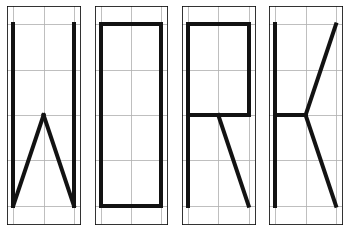


after 2 cycles:


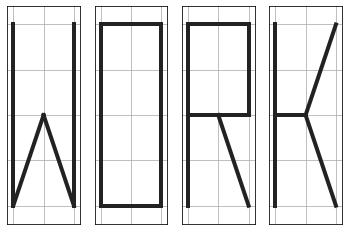


after 3 cycles:


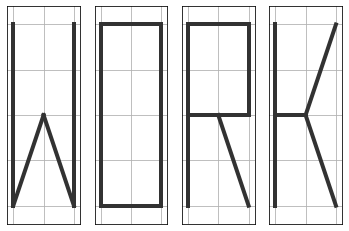


after 4 cycles:


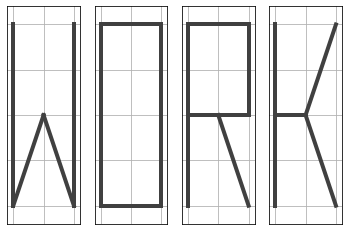


after 5 cycles:


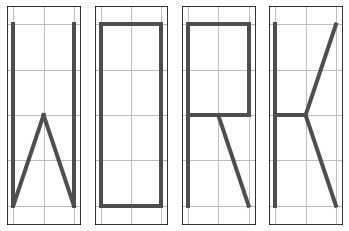


after 6 cycles:


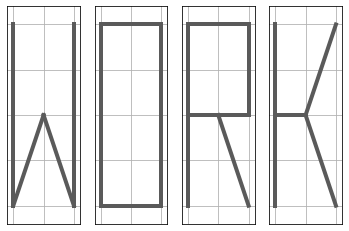


after 7 cycles:


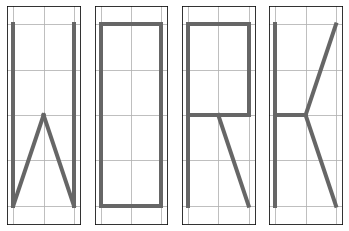


after 8 cycles:


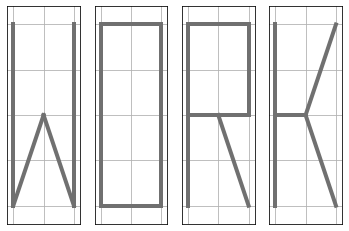


after 9 cycles:


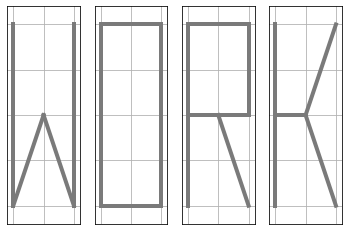


after 10 cycles:


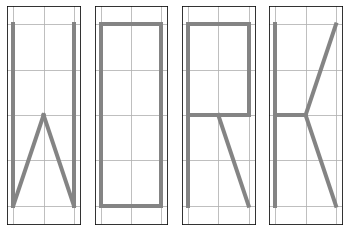

In [17]:
np.set_printoptions(precision=2, floatmode='fixed')
present_word('WORK')
print(feature_nodes)
for t in range(10):
    print(f'\nafter {t + 1} cycles:')
    f()
    draw_features()
    plt.show()

# Letter layer

In [20]:
letter_count = len(list(feature_numbers.keys()))
position_count = 4
r_letter = 0
letter_nodes = np.ones((position_count, letter_count)) * r_letter

In [23]:
def run_cycle():
    global feature_nodes, letter_nodes
    
    feature_decay, letter_decay = calculate_decay()
    feature_neighbours_effect, letter_neighbours_effect = calculate_neighbours_effect()
    
    feature_nodes += - feature_decay + feature_neighbours_effect
    letter_nodes += - letter_decay + letter_neighbours_effect

In [22]:
def calculate_decay():
    feature_decay = (feature_nodes - r_feature) * theta
    letter_decay = (letter_nodes - r_letter) * theta
    return feature_decay, letter_decay

In [21]:
def calculate_neighbours_effect():
    # There are no connections to the feature level except for the visual input
    feature_neighbours_effect = np.zeros(feature_nodes.shape)
    
    # Equation 1
    # Only the active (activation > 0) nodes get to send signals.
    # Inhibitory connections have negative weights in this implementation
    # This won't work! feature_nodes and letter_nodes would need to be vectors for this
    net_input = (feature_nodes * (feature_nodes > 0) @ feature_to_letter_weights
               + letter_nodes * (letter_nodes > 0) @ letter_to_letter_weights)
    
    # Equation 2 and 3
    letter_neighbours_effect = np.where(
        net_input > 0,
        net_input * (M - feature_nodes),
        net_input * (feature_nodes - m)
    )

In [ ]:
feature_to_letter_weights = ???
letter_to_letter_weights = ???